# CNN to Detect Presence of a Fracture in X-ray Images
### Diya Vinod

In [27]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [28]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

train_dir = "Bone_Fracture_Binary_Classification/train"
val_dir = "Bone_Fracture_Binary_Classification/val"
test_dir = "Bone_Fracture_Binary_Classification/test"

## Data preprocessing
- Normalize pixels
- Data augmentation to prevent overfitting and improve generalization

In [29]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [30]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    'Bone_Fracture_Binary_Classification/train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_data = val_datagen.flow_from_directory(
    'Bone_Fracture_Binary_Classification/val',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_data = test_datagen.flow_from_directory(
    'Bone_Fracture_Binary_Classification/test',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle = False
)
print("Train:", train_data.class_indices)
print("Val:", val_data.class_indices)
print("Test:", test_data.class_indices)

Found 9247 images belonging to 2 classes.
Found 829 images belonging to 2 classes.
Found 507 images belonging to 2 classes.
Train: {'fractured': 0, 'not fractured': 1}
Val: {'fractured': 0, 'not fractured': 1}
Test: {'fractured': 0, 'not fractured': 1}


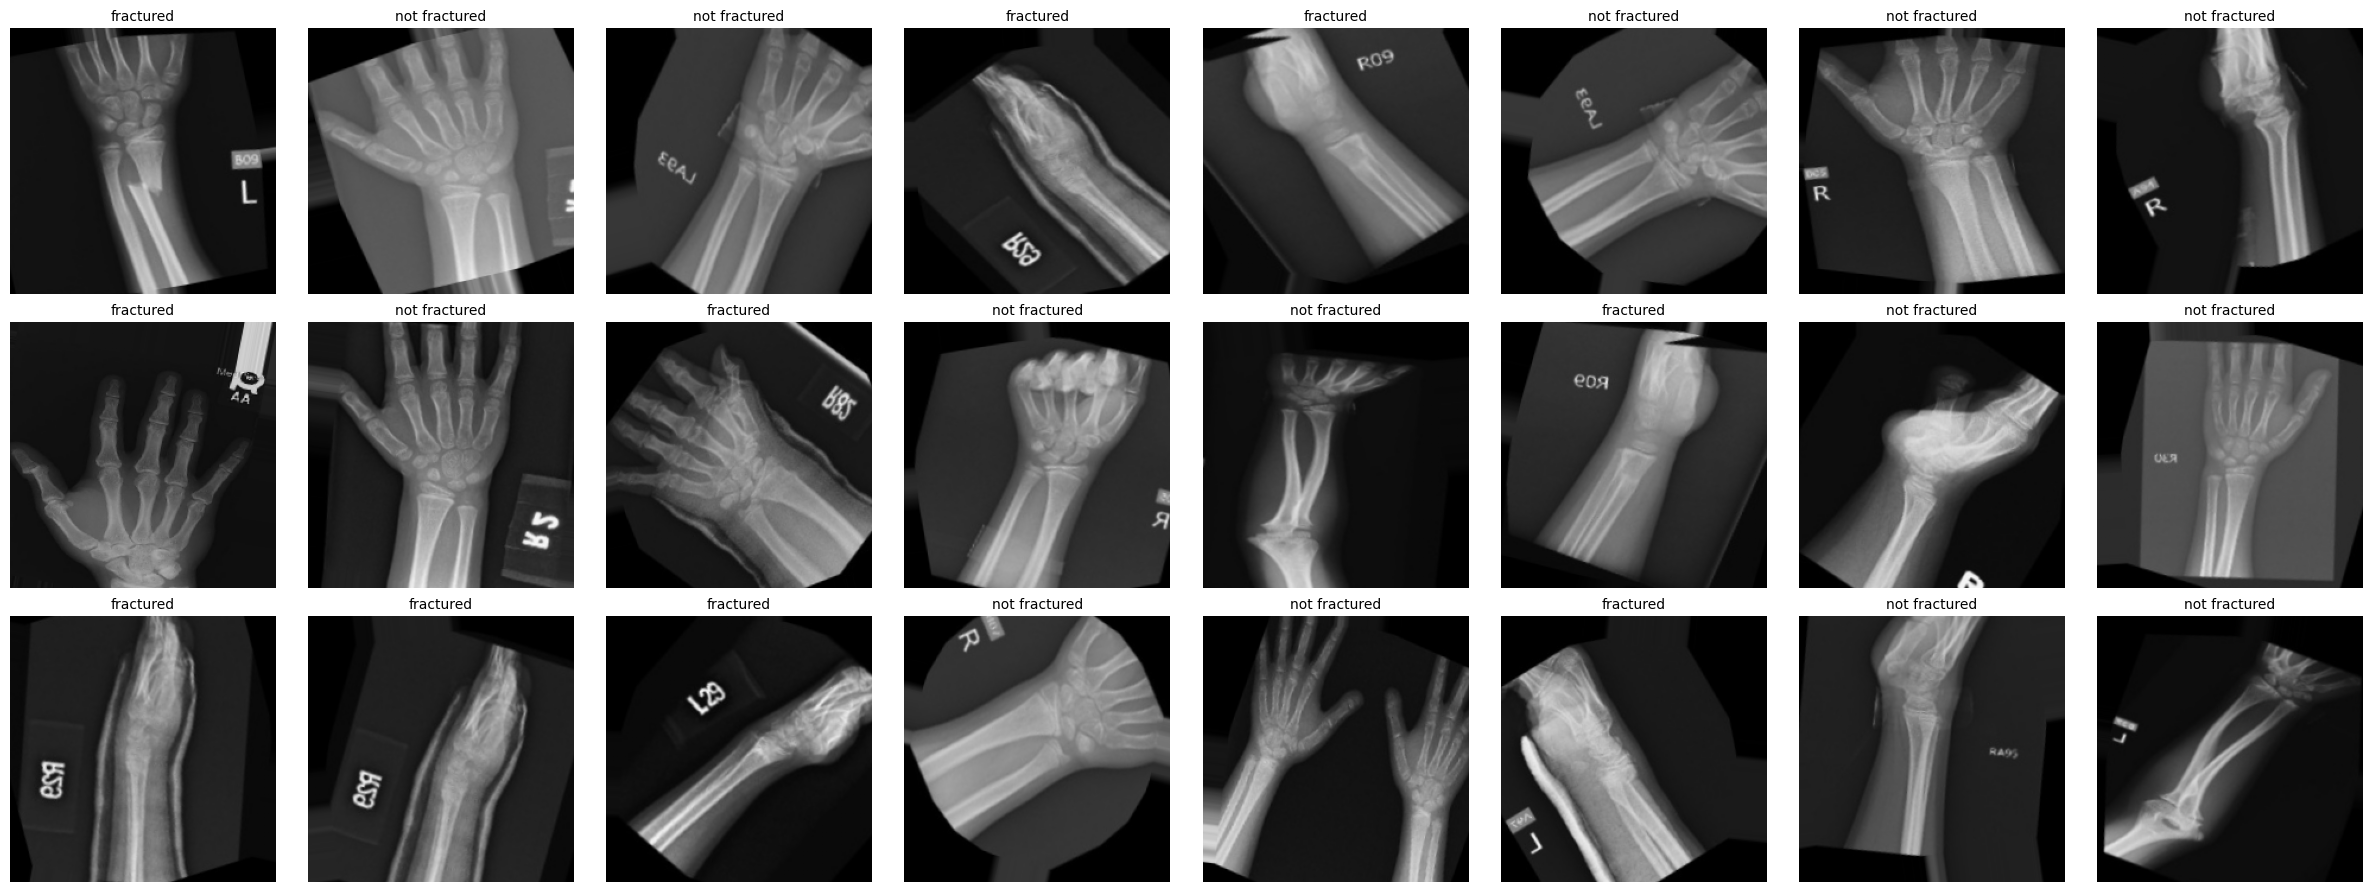

In [31]:
images, labels = next(train_data)

num_images = 24
rows = 3
cols = num_images // rows 

plt.figure(figsize=(cols * 3, rows * 3))  

for i in range(num_images):
    ax = plt.subplot(rows, cols, i + 1)
    plt.imshow(images[i])
    
    if labels[i].shape == ():  
        label_index = int(labels[i])
    else:  
        label_index = labels[i].argmax()
    
    class_name = list(train_data.class_indices.keys())[label_index]
    plt.title(class_name, fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Building the CNN Base

In [32]:
model = models.Sequential([

    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(256, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),

    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(1, activation='sigmoid')  
])
model.summary()

/Users/diyavinod/tf_env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     9,437,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,828,033 (37.49 MB)

 Trainable params: 9,827,073 (37.49 MB)

 Non-trainable params: 960 (3.75 KB)

## Compile and train the model

In [33]:
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.0006),
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,                  
    restore_best_weights=True    
)

checkpoint = ModelCheckpoint(
    'my_model.keras',
    monitor='val_loss',
    save_best_only=True
)

### Run on validation data

***Note: This can take an extremely long time to run! (I would recommend not rerunning this cell)***

In [35]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,                    
    callbacks=[early_stop, checkpoint]
)

Epoch 1/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 397s 1s/step - accuracy: 0.8641 - loss: 0.3342 - val_accuracy: 0.8637 - val_loss: 0.4378
Epoch 2/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 415s 1s/step - accuracy: 0.8909 - loss: 0.2738 - val_accuracy: 0.8287 - val_loss: 0.5027
Epoch 3/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 483s 2s/step - accuracy: 0.9190 - loss: 0.2180 - val_accuracy: 0.9228 - val_loss: 0.2146
Epoch 4/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 419s 1s/step - accuracy: 0.9305 - loss: 0.1815 - val_accuracy: 0.9252 - val_loss: 0.2299
Epoch 5/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 403s 1s/step - accuracy: 0.9435 - loss: 0.1533 - val_accuracy: 0.9385 - val_loss: 0.1734
Epoch 6/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 428s 1s/step - accuracy: 0.9495 - loss: 0.1293 - val_accuracy: 0.8794 - val_loss: 0.5246
Epoch 7/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 432s 1s/step - accuracy: 0.9576 - loss: 0.1218 - val_accuracy: 0.9324 - val_loss: 0.1502
Epoch 8/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 455s 2s/step - accuracy: 0.9587 - loss: 0.1139 - val_accu

## Plotting Accuracy over Epochs

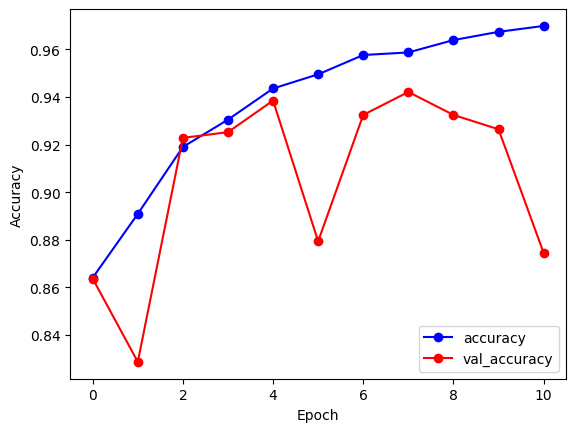

In [36]:
plt.plot(history.history['accuracy'], 'b-o', label='accuracy')
plt.plot(history.history['val_accuracy'], 'r-o', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

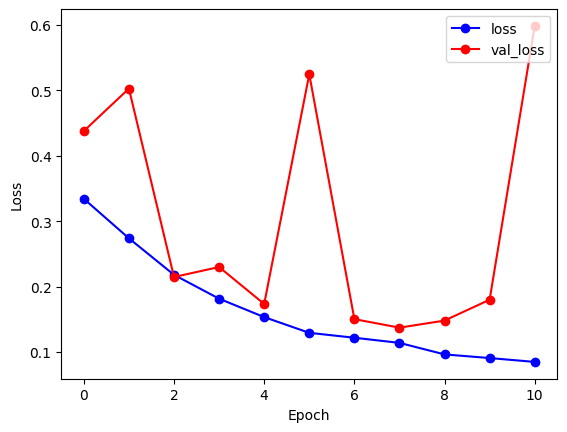

In [37]:
plt.plot(history.history['loss'], 'b-o', label='loss')
plt.plot(history.history['val_loss'], 'r-o', label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

### Evaluate the CNN Model on the Test Set

In [38]:
test_loss, test_acc = model.evaluate(test_data)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 247ms/step - accuracy: 0.9250 - loss: 0.1588
Test Loss: 0.15876978635787964
Test Accuracy: 0.9250493049621582


### Run the model on the test set

In [39]:
y_pred = model.predict(test_data)
y_pred_classes = (y_pred > 0.5).astype(int)

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 247ms/step


In [40]:
y_true = test_data.classes

***Select test data images with their predicted label vs their actual label***

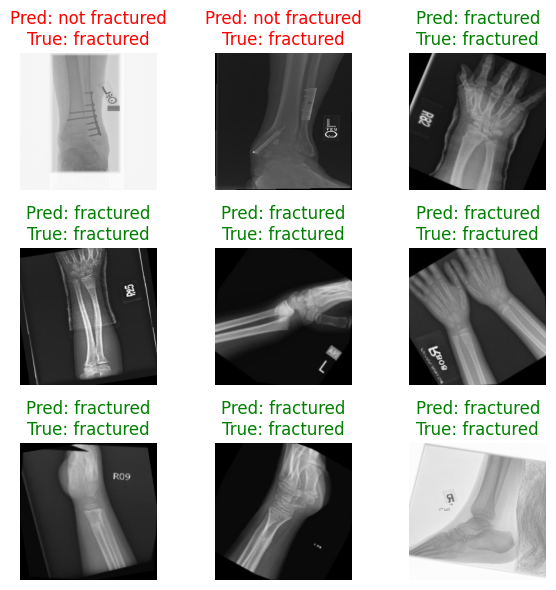

In [41]:
class_names = list(test_data.class_indices.keys())

num_images = 9

plt.figure(figsize=(6, 6))

for i in range(num_images):
    img, _ = test_data[i]  
    img = img[0]           

    pred_label = class_names[y_pred_classes[i].item()]
    true_label = class_names[y_true[i]]

    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis("off")
    
    color = "green" if pred_label == true_label else "red"
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)

plt.tight_layout()
plt.show()

### Confusion Matrix

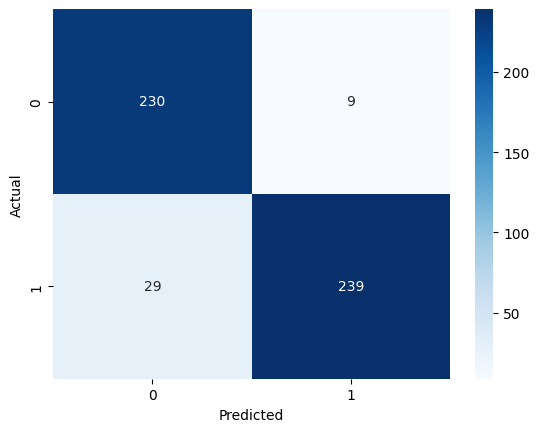

In [42]:
cm = confusion_matrix(y_true, y_pred_classes)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [43]:
print(classification_report(y_true, y_pred_classes))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92       239
           1       0.96      0.89      0.93       268

    accuracy                           0.93       507
   macro avg       0.93      0.93      0.93       507
weighted avg       0.93      0.93      0.93       507

